오늘 날짜 : 2022-01-17
GPU device : cuda:2
image.size() =  torch.Size([128, 1, 32, 32]) 	type torch.FloatTensor
label.size() =  torch.Size([128]) 	type torch.LongTensor


<Figure size 720x72 with 0 Axes>

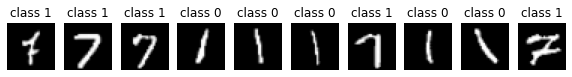

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import math
import itertools
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.autograd import Variable

import time
import datetime

args = {
        'GPU_NUM' : 2,
        'Epochs' : 200,
        'batch_size' : 128,
        'lr' : 0.0002,
        'b1' : 0.5,
        'b2' : 0.999,
        'latent_dim' : 62,
        'code_dim' : 2,
        'n_classes' : 2,
        'img_size' : 32,
        'channels' : 1,
        'sample_interval' : 400
        }

device = torch.device('cuda:{}'.format(args['GPU_NUM']) if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
today = datetime.date.today()
print('오늘 날짜 :',today)
print('GPU device :', device)

my_transform =transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(args['img_size']), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.5], [0.5])])

train_data = ImageFolder('data/MNIST/classes/binary/train', transform = my_transform)
test_data = ImageFolder('data/MNIST/classes/binary/test', transform = my_transform)

train_loader = DataLoader(train_data, batch_size=args['batch_size'], shuffle=True)
test_loader = DataLoader(test_data, batch_size=args['batch_size'], shuffle=True)

pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))
for image, label in train_loader:
    print('image.size() = ',image.size(), '\ttype', image.type())
    print('label.size() = ', label.size(), '\ttype', label.type())
    break

plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(image[i,:,:,:].permute(1,2,0), cmap="gray")
    plt.title('class '+ str(label[i].item()))


In [26]:
def to_np(tensor):
    return tensor.cpu().detach().numpy()

def weights_init_normal(m):
    """ Conv layer는 mean이 0, std가 0.02인 가우시안 분포로 weight init
        BatchNorm은 mean이 1, std가 0.02인 가우시안 분포로 weight init
        Bias term은 전부 0으로 초기화
    Args:
        m ([model]): 학습하려는 모델
    """
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def to_discrete(y, num_columns):
    """ onehot encoding
        (batch_size,)가 shape인 label이 있으면, (64,num_columns)인 zeros 행렬을 생성하고,
        (batch_size,)의 label vector element 값의 index만 1로 바꿔서 one-hot encoding함
    Args:
        y : 어떤 array (y.shape[0]는 batch_size로 보면 됨)
        num_columns : num_classes
    """
    y_disc = np.zeros((y.shape[0], num_columns))
    y_disc[range(y.shape[0]), y] = 1.0 # one-hot encoding()

    return Variable(FloatTensor(y_disc))


In [27]:
class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(ResidualBlock, self).__init__()

        #nn.Conv2d(input channel, output channel, ...)
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size = 3,
                               stride=stride,
                               padding=1,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(planes) # Batchnorm은 사이의 가중치가 아니라 출력 층만 노말라이징
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size = 3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size = 1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(planes))
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

class ResNet_3232(nn.Module):
    def __init__(self, channels = 1, num_classes = 10):
        super(ResNet_3232, self).__init__()
        
        self.rgb = channels
        self.in_planes = 16
        # RGB여서 3, in_planes는 내맘대로 16
        self.conv1 = nn.Conv2d(self.rgb,16,
                               kernel_size = 3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=2)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64,2)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] *(num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_planes,planes,stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self,x):
        out1 = F.relu(self.bn1(self.conv1(x)))
        out2 = self.layer1(out1)
        out3 = self.layer2(out2)
        out4 = self.layer3(out3)
        out5 = F.avg_pool2d(out4, 4)
        out6 = out5.view(out5.size(0), -1)
        out7 = self.linear(out6)
        
        return out7

In [28]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)


        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval ==0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))
    return output

def evaluate(model, test_loader):
    model.eval()
    test_loss=0
    correct=0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # output에서 제일 큰 놈의 index를 반환한다(이경우에 0 or 1)
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100*correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [29]:
# model = ResNet_3232(channels = args['channels'], num_classes=args['n_classes']).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# criterion = nn.CrossEntropyLoss()
# best_accuracy = 0
# for Epoch in range(1, 10+1):
#     train(model, train_loader, optimizer, log_interval=200)
#     test_loss, test_accuracy = evaluate(model, test_loader)
#     if test_accuracy > best_accuracy:
#         best_accuracy = test_accuracy
#         torch.save(model, 'pretrained_model/ResNet_3232_1_7.pt')
#         torch.save(model.state_dict(), 'pretrained_model/ResNet_3232_parameters_1_7.pt')
#     print("[EPOCH: {}], \tTest Loss: {:.4f},\tTest Accuracy: {:.2f}%\n".format(
#         Epoch, test_loss, test_accuracy))

In [411]:
# encoded output shape is (64, 4, 4)
# continuous dim = 1 (가장 중요한 code 하나만 뽑아보자)
# discrete dim = 2 (n_classes가 2)

args['cont_dim_P'] = 1
args['cont_dim_G'] = 2
args['disc_dim'] = 2
args['latent_dim'] = 32
args['reduced_dim'] = args['cont_dim_P'] + args['cont_dim_G'] + args['disc_dim'] + args['latent_dim'] # 37

class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
            
        self.input_dim = args['cont_dim_P']
        self.predictor = nn.Sequential(nn.Linear(self.input_dim, 128),nn.ReLU(), nn.Dropout(0.2),
                                        nn.Linear(128, 64), nn.ReLU(),nn.Dropout(0.2),
                                        nn.Linear(64,2)) # predict class (1 or 7)
        self.reduce_layer = nn.Linear(64*4*4, args['reduced_dim']) # 37 (total)
        self.cont_layer_P = nn.Linear(args['reduced_dim'], args['cont_dim_P']) 
        self.cont_layer_G = nn.Linear(args['reduced_dim'], args['cont_dim_G'])
        self.disc_layer = nn.Linear(args['reduced_dim'], args['disc_dim'], nn.Softmax())
        self.latent_layer = nn.Linear(args['reduced_dim'], args['latent_dim'])
        
    def reduce_and_split_encoded(self, encoded):
        encoded = encoded.view(encoded.shape[0], -1)
        reduced = self.reduce_layer(encoded)
        cont_code_P = self.cont_layer_P(reduced)
        cont_code_G = self.cont_layer_G(reduced)
        disc_code =  self.disc_layer(reduced)
        latent = self.latent_layer(reduced)
        return cont_code_P, cont_code_G, disc_code, latent
            
    def predict(self, cont_code_P):
        predicted = self.predictor(cont_code_P)
        return predicted
        
    def forward(self, encoded):
        cont_code_P, cont_code_G, disc_code, latent = self.reduce_and_split_encoded(encoded)
        predicted = self.predict(cont_code_P)
        return predicted, cont_code_P, cont_code_G, disc_code, latent

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        input_dim = args['reduced_dim'] # 32 + 2 + 2 + 1
        
        self.init_size = args['img_size'] // 4
        # conv에 넣을 수 있도록 dim_adjust
        self.fc = nn.Sequential(nn.Linear(input_dim, 128 * self.init_size * self.init_size ))
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128), nn.Upsample(scale_factor=2),
            nn.Conv2d(128,128,3, stride=1, padding=1), nn.BatchNorm2d(128,0.8), nn.LeakyReLU(0.2, inplace=True),
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128,64,3, stride=1, padding=1), nn.BatchNorm2d(64,0.8), nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64,args['channels'], 3, stride=1, padding=1), 
            nn.Tanh()
        )
        
    def forward(self, cont_code_P, cont_code_G, disc_code, latent):
        gen_input = torch.cat((cont_code_P, cont_code_G, disc_code, latent), dim=-1) # cat => 32+2+2+1 = 37 \
        # print(gen_input.shape, args['reduced_dim'])
        #  mat1 and mat2 shapes cannot be multiplied (128x37 and 36x8192)
        out = self.fc(gen_input)    
        out = out.view(out.shape[0], 128, self.init_size, self.init_size) # block화
        img = self.conv_blocks(out)
        
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_channels, out_channels, bn=True):
            block = [nn.Conv2d(in_channels, out_channels, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        # batchnorm을 넣을지 말지에 따라서 discriminator_block의 모듈 수가 달라진다
        # 달라지면 nn.Sequential에 추가할 때 if로 나눠서 해야하나? 싶지만
        # *를 사용하면 block안에 모듈이 몇개든 그냥 싹다 넣어주는 역할을 한다.
        self.conv_blocks = nn.Sequential(
            *discriminator_block(args['channels'], 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128)
        )
        
        downsample_size = args['img_size'] // (2**4) #stride 2인 block이 4개 있었으니까 4번 downsampled 
        
        self.adv_layer = nn.Sequential(nn.Linear(128*downsample_size*downsample_size, 1)) # real or fake 예측 
        self.disc_layer = nn.Sequential(nn.Linear(128*downsample_size*downsample_size, args['disc_dim']),
                                       ) # class 예측 
        self.cont_layer = nn.Sequential(nn.Linear(128*downsample_size*downsample_size, 
                                                    args['cont_dim_P']+args['cont_dim_G'])) # cont_code 예측
        
    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        reality = self.adv_layer(out)
        disc_pred = self.disc_layer(out)
        cont_pred = self.cont_layer(out)
        
        return reality, disc_pred, cont_pred

In [442]:
predict_loss = nn.CrossEntropyLoss().to(device)
recon_loss = nn.MSELoss().to(device)
adversarial_loss = nn.MSELoss().to(device)
discrete_loss = nn.CrossEntropyLoss().to(device)
continuous_loss = nn.MSELoss().to(device)

lambda_disc = 1
lambda_cont = 0.1 

pretrained_resnet = ResNet_3232(channels=1, num_classes=2).to(device)
pretrained_resnet.load_state_dict(torch.load('pretrained_model/ResNet_3232_parameters_1_7.pt'))

E = nn.Sequential(*(list(pretrained_resnet.children())[:5])).to(device)
P = Predictor().to(device)
G = Generator().to(device)
D = Discriminator().to(device)


P.apply(weights_init_normal)
G.apply(weights_init_normal)
D.apply(weights_init_normal)

# os.makedirs("../../data/mnist", exist_ok=True)
# dataloader = torch.utils.data.DataLoader(
#     datasets.MNIST(
#         root="../../data/mnist",
#         train=True,
#         download=True,
#         transform=transforms.Compose(
#             [transforms.Resize(args['img_size']), 
#              transforms.ToTensor(), 
#              transforms.Normalize([0.5], [0.5])]
#         ),
#     ),
#     batch_size=args['batch_size'],
#     shuffle=True,
# )

optimizer_P = torch.optim.Adam(P.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
optimizer_G = torch.optim.Adam(G.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
optimizer_D = torch.optim.Adam(D.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
optimizer_info = torch.optim.Adam(
    itertools.chain(P.parameters(),G.parameters(), D.parameters()), lr=args['lr'], betas=(args['b1'], args['b2'])
)

FloatTensor = torch.cuda.FloatTensor if (device == 'cuda') else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if (device == 'cuda') else torch.LongTensor

def sample_image(n_row, batches_done):
    """noise에 의한 이미지 변화만 볼거라서 code는 0으로 다 고정"""
    # 10*10 짜리 grid 만들려고 batch_size를 100으로 하는거임 => 10개 클래스 이미지를 10등분으로 interpolation
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, args['latent_dim']))))
    static_label = to_discrete(np.array([num for _ in range(args.n_classes) for num in range(args['n_classes'])]), 
                               args['n_classes']) 
    static_code = Variable(FloatTensor(np.zeros((args['n_classes']**2, args['code_dim']))))
    static_sample = G(z, static_label, static_code)
    save_image(static_sample.data, "images/static/%d.png" % batches_done, nrow=n_row, normalize=True)

    """code의 interpolation에 의한 이미지 변화만 볼거라서 noise도 0으로 다 고정"""
    static_z = Variable(FloatTensor(np.zeros((args['n_classes']**2, args['latent_dim']))))
    # code 하나 고정용 벡터 생성
    zeros = np.zeros((n_row ** 2, 1))
    # n_row(10)번만큼 반복되는 interpolation 생성 ex) 2번 반복 [[-1],[0],[1]] => [[-1],[-1],[0],[0],[1],[1]]
    c_varied = np.repeat(np.linspace(-1, 1, n_row)[:, np.newaxis], n_row, 0)
    # code 하나는 0으로 고정하고 나머지 code 하나를 -1에서 1로 interpolation한 tensor 생성 (100,2)
    c1 = Variable(FloatTensor(np.concatenate((c_varied, zeros), -1)))
    c2 = Variable(FloatTensor(np.concatenate((zeros, c_varied), -1)))
    # 0~9까지 class에서 하나씩만 뽑아(static_label) interpolation한 code로 image 생성
    sample1 = G(static_z, static_label, c1)
    sample2 = G(static_z, static_label, c2)
    save_image(sample1.data, "images/varying_c1/%d.png" % batches_done, nrow=n_row, normalize=True)
    save_image(sample2.data, "images/varying_c2/%d.png" % batches_done, nrow=n_row, normalize=True)

In [443]:
for i, (imgs,labels) in enumerate(train_loader):
    batch_size = imgs.shape[0]
    
    real = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
    fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)
    real_imgs = Variable(imgs.type(FloatTensor))
    labels = to_discrete(labels.numpy(), args['n_classes'])
    break

sampled_labels = np.random.randint(0,args['n_classes'], batch_size)
labels.shape

torch.Size([128, 2])

In [444]:
start = time.time() ; print('Training starts!')

for epoch in range(args['Epochs']):
    for i, (imgs,labels) in enumerate(train_loader):
        batch_size = imgs.shape[0]
        real = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)
        
        real_imgs = Variable(imgs.type(FloatTensor)).to(device)
        labels = to_discrete(labels.numpy(), args['n_classes']).to(device)
        
        encoded = E(real_imgs)
        
        
        # -----------------
        #  Train Predictor
        # -----------------
        optimizer_P.zero_grad()
        
        predicted, _, _, _, _ = P(encoded)
        loss_P = predict_loss(predicted, labels)

        loss_P.backward(retain_graph=True)
        optimizer_P.step()
        
        # -----------------
        #  Train Generator (input = latent, label, code)
        # -----------------
        optimizer_G.zero_grad()
        
        
        # z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, args['latent_dim']))))
        # label_input = to_discrete(np.random.randint(0, args['n_classes'], batch_size), args['n_classes'])
        # code_input = Variable(FloatTensor(np.random.uniform(-1,1, (batch_size, args['cont_dim']))))
        _, cont_code_P, cont_code_G, disc_code, latent = P(encoded)
        fake_imgs = G(cont_code_P, cont_code_G, disc_code, latent)
        reality, _, _ = D(fake_imgs)
        
        loss_adv = adversarial_loss(reality, real) # fake_imgs의 분류(D) 결과가 최대한 1(real)로 분류되도록 G 학습
        loss_recon = recon_loss(real_imgs, fake_imgs)
        loss_G = loss_adv + 100*loss_recon
        loss_G.backward(retain_graph=True)
        optimizer_G.step()
    
        # -----------------
        #  Train Discriminator
        # -----------------
        optimizer_D.zero_grad()
        
        # real or fake pred score
        pred_real, _, _ = D(real_imgs)
        pred_fake, _, _ = D(fake_imgs.detach())
        loss_D_real = adversarial_loss(pred_real, real) # real_imgs는 D가 1(real)로 분류하도록 D 학습 
        loss_D_fake = adversarial_loss(pred_fake, fake) # fake_imgs는 D가 0(fake)로 분류하도록 D 학습
        loss_D = (loss_D_real + loss_D_fake) / 2
        
        loss_D.backward(retain_graph=True)
        optimizer_D.step()
        
        # ------------------
        # Information Loss
        # ------------------
        optimizer_info.zero_grad()
        
        # sampled_labels = labels
        
        # gt_labels = Variable(disc_code, requires_grad=False).to(device)
        
        # z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, args['latent_dim']))))
        
        label_input = to_discrete(sampled_labels, args['n_classes'])
        code_input = Variable(FloatTensor(np.random.uniform(-1, 1, (batch_size, args['cont_dim']))))
        
        fake_imgs = G(cont_code_P, cont_code_G, disc_code, latent)
        _, pred_label, pred_code = D(fake_imgs) # D라고 해놨지만 Q head의 출력임
        cont_code = torch.cat((cont_code_P, cont_code_G), dim=-1)
        # loss_info_disc = lambda_disc * discrete_loss(pred_label, gt_labels) # 실제 레이블 예측(이산 CELoss)
        loss_info_cont = lambda_cont * continuous_loss(pred_code, cont_code)# code input 예측(연속 MSELoss)
        loss_info =  loss_info_cont
                    
        loss_info.backward()
        optimizer_info.step()
        
        # code만 고정된 경우 생성 image와 code만 interpolation하는 경우 생성 image 저장
        batches_done = epoch * len(train_loader) + i
        # if batches_done % args['sample_interval'] == 0:
        #     sample_image(n_row=10, batches_done=batches_done)
            
    # --------------
    # Log Progress
    # --------------
    print(
        "[Epoch %d/%d] [P loss: %.4f] [D loss: %.4f] [G loss: %.4f] [info disc: %.4f] [info cont: %.4f] [time: %.1f]"
        % (epoch, args['Epochs'], 
        #    i, len(train_loader),
           loss_P.item(),
           loss_D.item(), 
           loss_G.item(), 
        #    loss_info_disc.item(),
            0,
           loss_info_cont.item(),
           time.time()-start)
    )
        

Training starts!
[Epoch 0/200] [P loss: 0.0468] [D loss: 0.0384] [G loss: 37.3640] [info disc: 0.0000] [info cont: 0.0219] [time: 8.0]
[Epoch 1/200] [P loss: 0.0322] [D loss: 0.0190] [G loss: 17.7814] [info disc: 0.0000] [info cont: 0.0108] [time: 16.6]
[Epoch 2/200] [P loss: 0.0235] [D loss: 0.0138] [G loss: 15.8400] [info disc: 0.0000] [info cont: 0.0168] [time: 24.6]
[Epoch 3/200] [P loss: 0.0014] [D loss: 0.0327] [G loss: 11.9513] [info disc: 0.0000] [info cont: 0.0078] [time: 32.5]
[Epoch 4/200] [P loss: 0.0025] [D loss: 0.0882] [G loss: 10.7631] [info disc: 0.0000] [info cont: 0.0061] [time: 40.3]
[Epoch 5/200] [P loss: 0.0561] [D loss: 0.2333] [G loss: 11.8809] [info disc: 0.0000] [info cont: 0.0238] [time: 48.0]
[Epoch 6/200] [P loss: 0.0016] [D loss: 0.2601] [G loss: 12.3405] [info disc: 0.0000] [info cont: 0.0061] [time: 55.5]
[Epoch 7/200] [P loss: 0.0022] [D loss: 0.0167] [G loss: 11.6003] [info disc: 0.0000] [info cont: 0.0066] [time: 62.3]
[Epoch 8/200] [P loss: 0.0011] [

In [445]:
print(pred_label[0])
print(gt_labels[0])

print(pred_code[0])
print(cont_code[0])

tensor([0.0367, 0.0079], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([-153.2464,  -73.7961], device='cuda:2')
tensor([-0.5931, -0.0178,  0.0176], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([-0.6220, -0.0603,  0.0923], device='cuda:2', grad_fn=<SelectBackward0>)


In [446]:
for iamge, label in test_loader:
    image = image.to(device)
    encoded = E(image)
    predicted, cont_code_P, cont_code_G, disc_code, latent = P(encoded)
    fake_imgs = G(cont_code_P, cont_code_G, disc_code, latent)
    break

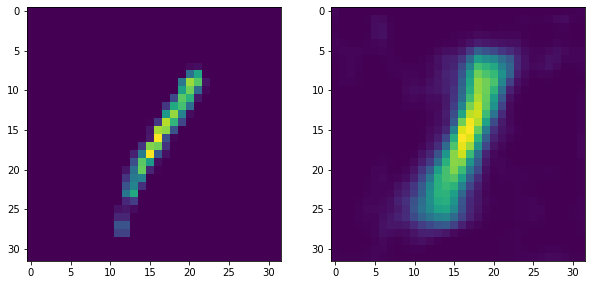

In [464]:
IDX = 16

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(image[IDX].permute(1,2,0).cpu().detach().numpy())
plt.subplot(1,2,2)
plt.imshow(fake_imgs[IDX].permute(1,2,0).cpu().detach().numpy())

In [ ]:
predicted,_,_,_,_ = P(encoded)

In [347]:
predicted, cont_code_P, cont_code_G, disc_code, latent = P(encoded)
fake = G(cont_code_P, cont_code_G, disc_code, latent)

save_image(fake,"apapap.png", nrow=10, normalize=True)

In [348]:
n_row = 10
zeros = np.zeros((n_row ** 2, 1))
cont_P_varied = np.repeat(np.linspace(-2, 2, n_row)[:, np.newaxis], n_row, 0)
cont_G_varied = np.repeat(np.linspace(-1, 1, n_row)[:, np.newaxis], n_row, 0)
c1 = Variable(FloatTensor(np.concatenate((cont_G_varied, zeros), -1))).to(device)
fake_p = G(FloatTensor(cont_P_varied).to(device), cont_code_G[:100], disc_code[:100], latent[:100])
fake_g = G(cont_code_P[:100], c1.to(device), disc_code[:100], latent[:100])
save_image(fake_g,"varied_c2.png", nrow=10, normalize=True)


In [336]:
print(torch.min(cont_code_G), torch.max(cont_code_G))
print(torch.min(cont_code_P), torch.max(cont_code_P))

tensor(-0.7153, device='cuda:2', grad_fn=<MinBackward1>) tensor(0.3685, device='cuda:2', grad_fn=<MaxBackward1>)
tensor(-2.3641, device='cuda:2', grad_fn=<MinBackward1>) tensor(2.5974, device='cuda:2', grad_fn=<MaxBackward1>)


In [337]:
torch.max(cont_code_P)

tensor(2.5974, device='cuda:2', grad_fn=<MaxBackward1>)

In [218]:
def sample_image(n_row, batches_done):
    """noise에 의한 이미지 변화만 볼거라서 code는 0으로 다 고정"""
    # 10*10 짜리 grid 만들려고 batch_size를 100으로 하는거임 => 10개 클래스 이미지를 10등분으로 interpolation
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, args['latent_dim']))))
    static_label = to_discrete(np.array([num for _ in range(args.n_classes) for num in range(args['n_classes'])]), 
                               args['n_classes']) 
    static_code = Variable(FloatTensor(np.zeros((args['n_classes']**2, args['code_dim']))))
    static_sample = G(z, static_label, static_code)
    save_image(static_sample.data, "images/static/%d.png" % batches_done, nrow=n_row, normalize=True)

    """code의 interpolation에 의한 이미지 변화만 볼거라서 noise도 0으로 다 고정"""
    static_z = Variable(FloatTensor(np.zeros((args['n_classes']**2, args['latent_dim']))))
    # code 하나 고정용 벡터 생성
    zeros = np.zeros((n_row ** 2, 1))
    # n_row(10)번만큼 반복되는 interpolation 생성 ex) 2번 반복 [[-1],[0],[1]] => [[-1],[-1],[0],[0],[1],[1]]
    c_varied = np.repeat(np.linspace(-1, 1, n_row)[:, np.newaxis], n_row, 0)
    # code 하나는 0으로 고정하고 나머지 code 하나를 -1에서 1로 interpolation한 tensor 생성 (100,2)
    c1 = Variable(FloatTensor(np.concatenate((c_varied, zeros), -1)))
    c2 = Variable(FloatTensor(np.concatenate((zeros, c_varied), -1)))
    # 0~9까지 class에서 하나씩만 뽑아(static_label) interpolation한 code로 image 생성
    sample1 = G(static_z, static_label, c1)
    sample2 = G(static_z, static_label, c2)
    save_image(sample1.data, "images/varying_c1/%d.png" % batches_done, nrow=n_row, normalize=True)
    save_image(sample2.data, "images/varying_c2/%d.png" % batches_done, nrow=n_row, normalize=True)

In [406]:
a = torch.tensor([[1,0],
                  [1,0],
                  [0,1]],dtype=torch.float32)
b = torch.randn(a.shape) 

discrete_loss(a,b)

tensor(-100.2998)